In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import os
os.chdir('../selfplay/')

In [2]:
results = []
first_moves = []
len_games = []
try:
    i = 0
    while True:
        x = np.load(str(i).zfill(5) + '.npz')
        results.append(x['result'].item())
        first_moves.append(x['moves'][0])
        len_games.append(len(x['moves']))
        i += 1
except FileNotFoundError:
    pass
results = np.array(results)
first_moves = np.array(first_moves)
print(f'Got {len(results)} games')

Got 2000 games


In [3]:
data = pd.DataFrame(columns=['Games', 'X', 'O', 'T'])
for i in range(0, len(results), 500):
    hist = np.histogram(results[i:i+500], bins=[1,2,3,4], density=True)[0]
    data = data.append({'Games': f'{i}-{i+500}',
                        'X': hist[0],
                        'O': hist[1],
                        'T': hist[2],
                        }, ignore_index=True)
data = data.melt(id_vars='Games', var_name='Result', value_name='Percent')

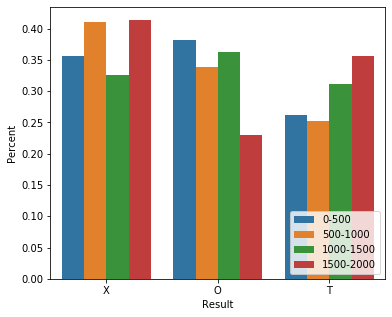

In [4]:
# Note: seaborn error bars are 95% CI of mean
plt.figure(figsize=(6, 5))
sns.barplot(x='Result', y='Percent', hue='Games', data=data, ci=None)
plt.legend(loc='lower right')
plt.show()

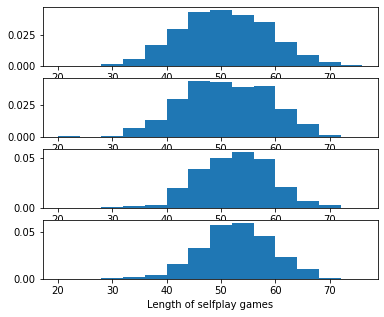

In [5]:
n = (len(results)+499) // 500
plt.subplots(figsize=(6,5))
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.hist(len_games[500*i:500*(i+1)], bins=np.arange(20, 80, 4), density=True)
plt.xlabel('Length of selfplay games')
plt.show()

In [6]:
def plot_first_moves(first_moves):
    grid = np.zeros((9,9))
    for move in first_moves:
        grid[move[0], move[1]] += 1
    grid

    grid = torch.tensor(grid).view(3, 3, 3, 3)
    grid = torch.cat(grid.chunk(3, dim=0), dim=2)
    grid = torch.cat(grid.chunk(3, dim=1), dim=3)
    grid = grid.squeeze()
    
    plt.imshow(grid, vmin=0)
    plt.colorbar()

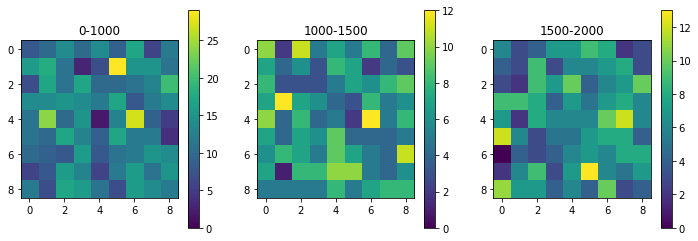

In [7]:
plt.subplots(figsize=(12, 4))
plt.subplot(131)
plot_first_moves(first_moves[:1000])
plt.title('0-1000')
plt.subplot(132)
plot_first_moves(first_moves[1000:1500])
plt.title('1000-1500')
plt.subplot(133)
plot_first_moves(first_moves[1500:2000])
plt.title('1500-2000')
plt.show()

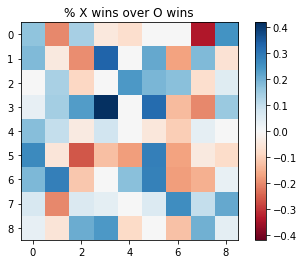

In [16]:
grid = np.zeros((9,9))
gridX = np.zeros((9,9))
gridO = np.zeros((9,9))
for move, r in zip(first_moves, results):
    grid[move[0], move[1]] += 1
    if r == 1:
        gridX[move[0], move[1]] += 1
    elif r == 2:
        gridO[move[0], move[1]] += 1
grid = (gridX - gridO) / grid

grid = torch.tensor(grid).view(3, 3, 3, 3)
grid = torch.cat(grid.chunk(3, dim=0), dim=2)
grid = torch.cat(grid.chunk(3, dim=1), dim=3)
grid = grid.squeeze()

plt.imshow(grid, 
           vmin=-grid.abs().max(), 
           vmax=grid.abs().max(),
           cmap='RdBu')
plt.colorbar()
plt.title('% X wins over O wins')
plt.show()